## Deep Convolutional Generative Adversarial Networks (2016)
- Gan using deep convolutional network

## Features
- do not use FC layer for hidden layer
- use strided convolutions instead of Pooling layer for down sampling in Discriminator
- use fractional-strided convolutions(deconvolution) in Generator
- use Batchnormalization in both the generator and the discriminator
- use ReLU in Generator except for the output layer(tanh)
- use LeakyReLu in Discriminator
- initialize all weights with small random values (noraml distribution, mean=0, stdev=0.02)
- use Binary Cross Entropy for loss function

## Dataset
- Fashion MNist

## Import Modules

In [75]:
import sys
sys.path.insert(0, '../')

import os
import cv2
import tqdm
import random

import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

from utils import imshow, get_mean

random_seed = 123

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download Fashion MNist
- We don't validate or test here.

In [2]:
os.makedirs('../dataset', exist_ok=True)

train_data = FashionMNIST('../dataset', train=True, download=True)
#test_data = FashionMNIST('../dataset', train=False, download=True)

In [3]:
classes = train_data.classes
train_images, train_labels = train_data.data, train_data.targets
#test_images, test_labels = test_data.data, test_data.targets

print(f"{len(train_images)} train images...")
#print(f"{len(test_images)} test images...")

60000 train images...


<Figure size 864x288 with 0 Axes>

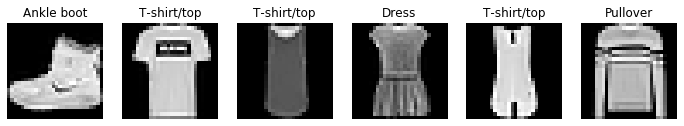

In [4]:
imshow(train_images[:6], train_labels[:6], classes)

## Build Network

### torch.nn.ConvTranspose2d
- Parameters
    - in_channels (int)
    - out_channels (int)
    - kernel_size (int or tuple)
    - stride (int or tuple, optional)
    - padding (int or tuple, optional)
    - output_padding (int or tuple, optional)

### find appropriate parameters
- our target output size is (1 x 28 x 28)

In [5]:
# Generator
x = torch.randn(1, 100, 1, 1)
print(x.shape)
x = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)(x)
print(x.shape)
x = nn.ConvTranspose2d(512, 256, 4, 1, 0, bias=False)(x)
print(x.shape)
x = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)(x)
print(x.shape)
x = nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False)(x)
print(x.shape)

torch.Size([1, 100, 1, 1])
torch.Size([1, 512, 4, 4])
torch.Size([1, 256, 7, 7])
torch.Size([1, 128, 14, 14])
torch.Size([1, 1, 28, 28])


In [6]:
# Discriminator
x = torch.randn(1, 1, 28, 28)
print(x.shape)
x = nn.Conv2d(1, 128, 4, 2, 1, bias=False)(x)
print(x.shape)
x = nn.Conv2d(128, 256, 4, 2, 1, bias=False)(x)
print(x.shape)
x = nn.Conv2d(256, 512, 4, 2, 1, bias=False)(x)
print(x.shape)
x = nn.Conv2d(512, 512, 4, 2, 1, bias=False)(x)
print(x.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 128, 14, 14])
torch.Size([1, 256, 7, 7])
torch.Size([1, 512, 3, 3])
torch.Size([1, 512, 1, 1])


### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # smaller than the paper architecture
        self.model = nn.Sequential(
            # (1 x 1) -> (4 x 4)
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # (4 x 4) -> (7 x 7)
            nn.ConvTranspose2d(512, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # (7 x 7) -> (14 x 14)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (14 x 14) -> (28 x 28)
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

### Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # (28 x 28) -> (14 x 14)
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # (14 x 14) -> (7 x 7)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # (7 x 7) -> (3 x 3)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # (3 x 3) -> (1 x 1)
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1)

In [9]:
G = Generator().to(device)
D = Discriminator().to(device)

### weight initialize

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(f"initialized {classname}")

In [11]:
G.apply(weights_init)
D.apply(weights_init)
print("success")

initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized Tanh
initialized Sequential
initialized Generator
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized Sigmoid
initialized Sequential
initialized Discriminator
success


## Sampling function
- sampling latent z
- z.shape -> (batch_size, dim, 1, 1)

In [12]:
def sample_z(num=1, dim=100):
    return torch.randn(num, dim, 1, 1)

<Figure size 864x288 with 0 Axes>

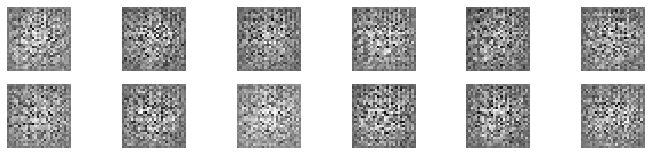

In [13]:
fake = G(sample_z(12, 100).to(device))
imshow(fake.detach().cpu().reshape(-1, 28, 28))

## Hyperparameters

In [14]:
batch_size    = 16
learning_rate = 0.001
epochs        = 20

## Optimizer

In [15]:
optim_D = optim.Adam(D.parameters(), learning_rate)
optim_G = optim.Adam(G.parameters(), learning_rate)

## Loss Function

In [16]:
bce = F.binary_cross_entropy
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)

def loss_fn_D(D, G, real, fake):
    return bce(D(real), ones) + bce(D(fake), zeros)

def loss_fn_G(D, G, fake):
    return bce(D(fake), ones)

## Build CustomDataset and Dataloader

In [17]:
class CustomDataset(Dataset):
    def __init__(self):
        super(CustomDataset).__init__()
        
        self.xs = train_images * (2 / 255) - 1.
        print(f"normalized [{self.xs.min()}, {self.xs.max()}]")
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        return x.view(1, 28, 28)

In [18]:
dataloader_params = {'batch_size': batch_size,
                     'shuffle': True,
                     'drop_last': True,
                     'num_workers': 0}

train_ds = CustomDataset()
train_gen = DataLoader(train_ds, **dataloader_params)

normalized [-1.0, 1.0]


## Training

Epoch 0/20 G_loss : 6.600126 D_loss : 0.326032: 100%|██████████████████████████████| 3750/3750 [01:10<00:00, 53.51it/s]


<Figure size 864x288 with 0 Axes>

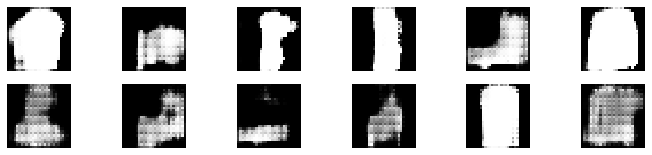

Epoch 1/20 G_loss : 4.208193 D_loss : 0.491569: 100%|██████████████████████████████| 3750/3750 [01:11<00:00, 52.42it/s]


<Figure size 864x288 with 0 Axes>

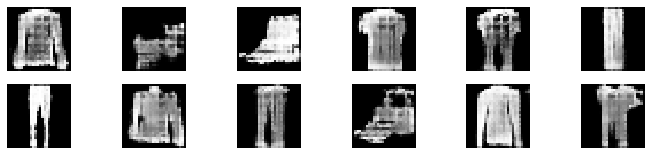

Epoch 2/20 G_loss : 3.681736 D_loss : 0.507936: 100%|██████████████████████████████| 3750/3750 [01:09<00:00, 53.96it/s]


<Figure size 864x288 with 0 Axes>

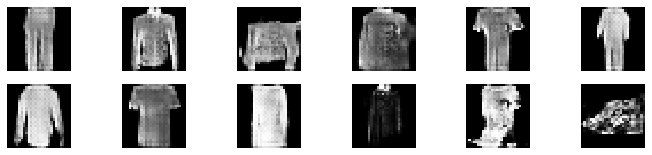

Epoch 3/20 G_loss : 3.700537 D_loss : 0.455088: 100%|██████████████████████████████| 3750/3750 [01:09<00:00, 53.87it/s]


<Figure size 864x288 with 0 Axes>

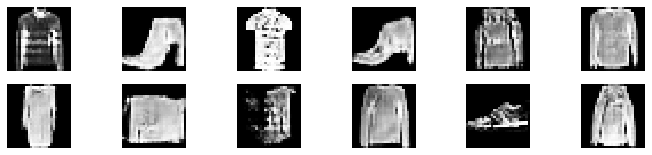

Epoch 4/20 G_loss : 3.787971 D_loss : 0.431181: 100%|██████████████████████████████| 3750/3750 [01:08<00:00, 54.56it/s]


<Figure size 864x288 with 0 Axes>

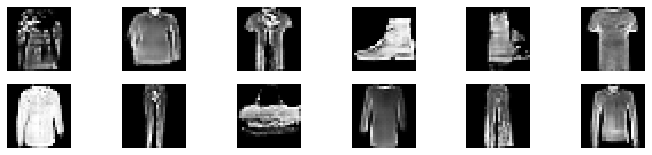

Epoch 5/20 G_loss : 3.777104 D_loss : 0.410535: 100%|██████████████████████████████| 3750/3750 [01:08<00:00, 54.63it/s]


<Figure size 864x288 with 0 Axes>

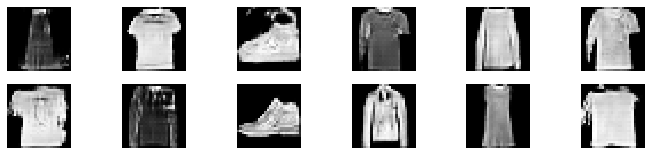

Epoch 6/20 G_loss : 3.824867 D_loss : 0.413008: 100%|██████████████████████████████| 3750/3750 [01:09<00:00, 54.34it/s]


<Figure size 864x288 with 0 Axes>

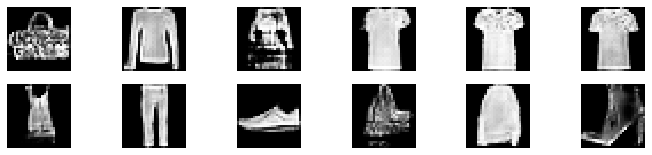

Epoch 7/20 G_loss : 3.778599 D_loss : 0.403711: 100%|██████████████████████████████| 3750/3750 [01:09<00:00, 53.98it/s]


<Figure size 864x288 with 0 Axes>

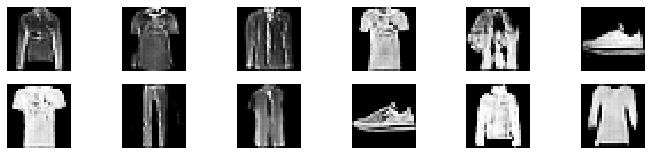

Epoch 8/20 G_loss : 3.797127 D_loss : 0.417764: 100%|██████████████████████████████| 3750/3750 [01:09<00:00, 54.27it/s]


<Figure size 864x288 with 0 Axes>

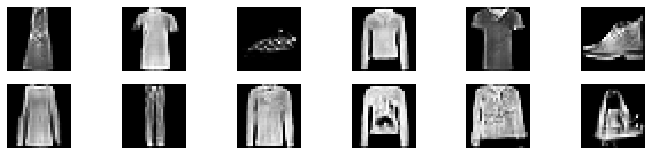

Epoch 9/20 G_loss : 3.855084 D_loss : 0.391222: 100%|██████████████████████████████| 3750/3750 [01:08<00:00, 54.49it/s]


<Figure size 864x288 with 0 Axes>

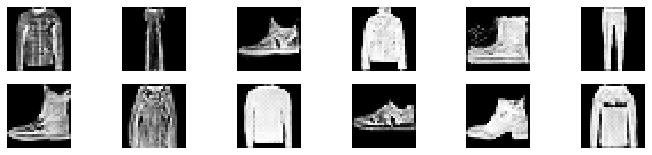

Epoch 10/20 G_loss : 3.903346 D_loss : 0.385596: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.61it/s]


<Figure size 864x288 with 0 Axes>

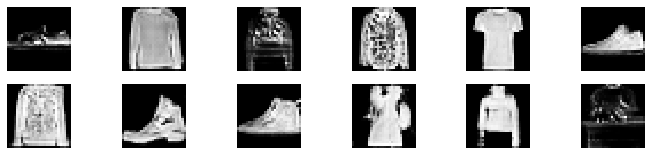

Epoch 11/20 G_loss : 3.961593 D_loss : 0.371056: 100%|█████████████████████████████| 3750/3750 [01:09<00:00, 54.12it/s]


<Figure size 864x288 with 0 Axes>

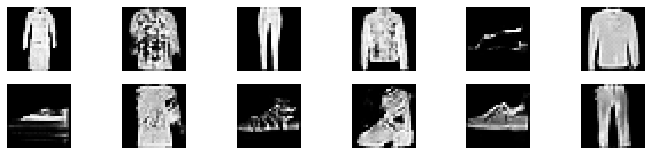

Epoch 12/20 G_loss : 4.036459 D_loss : 0.358336: 100%|█████████████████████████████| 3750/3750 [01:09<00:00, 53.82it/s]


<Figure size 864x288 with 0 Axes>

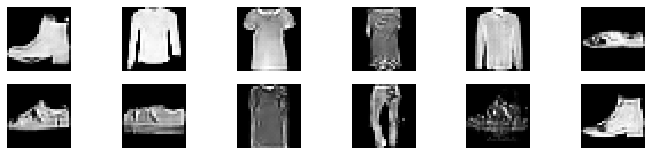

Epoch 13/20 G_loss : 4.143550 D_loss : 0.352004: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.53it/s]


<Figure size 864x288 with 0 Axes>

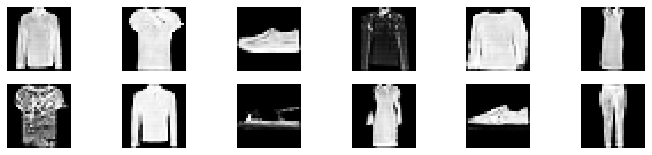

Epoch 14/20 G_loss : 4.216087 D_loss : 0.344806: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.57it/s]


<Figure size 864x288 with 0 Axes>

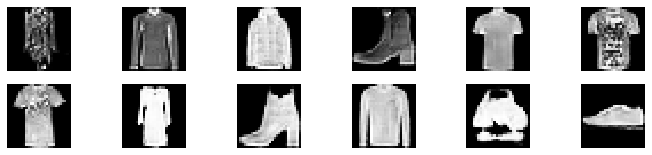

Epoch 15/20 G_loss : 4.234796 D_loss : 0.346387: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.55it/s]


<Figure size 864x288 with 0 Axes>

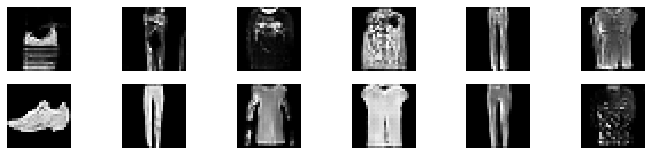

Epoch 16/20 G_loss : 4.307887 D_loss : 0.327336: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.46it/s]


<Figure size 864x288 with 0 Axes>

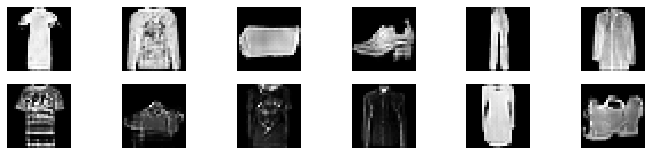

Epoch 17/20 G_loss : 4.392772 D_loss : 0.308856: 100%|█████████████████████████████| 3750/3750 [01:08<00:00, 54.54it/s]


<Figure size 864x288 with 0 Axes>

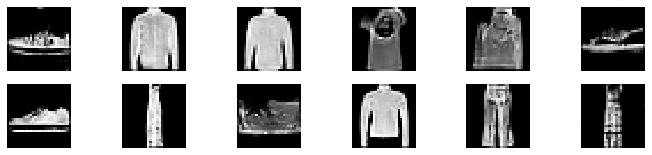

Epoch 18/20 G_loss : 4.500123 D_loss : 0.308179: 100%|█████████████████████████████| 3750/3750 [01:11<00:00, 52.70it/s]


<Figure size 864x288 with 0 Axes>

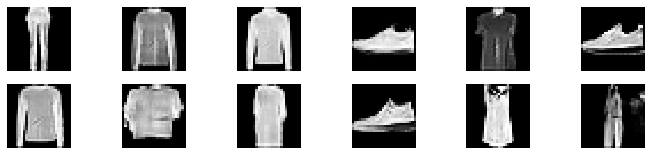

Epoch 19/20 G_loss : 4.553226 D_loss : 0.313968: 100%|█████████████████████████████| 3750/3750 [01:10<00:00, 52.90it/s]


<Figure size 864x288 with 0 Axes>

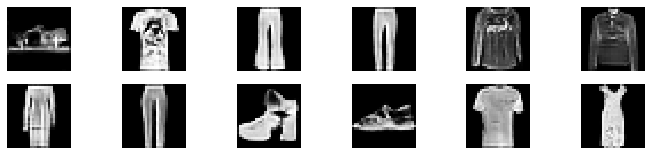

In [19]:
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    
    D.train()
    G.train()
    
    pgbar = tqdm.tqdm(train_gen, total=len(train_gen))
    for real in pgbar:
        
        # train Discriminator
        real = real.to(device)
        z    = sample_z(batch_size).to(device)
        
        fake = G(z)
        
        optim_D.zero_grad()
        d_loss = loss_fn_D(D, G, real, fake)
        d_loss.backward()
        optim_D.step()
    
        # train Generator
        z    = sample_z(batch_size).to(device)
        
        fake = G(z)
        
        optim_G.zero_grad()
        g_loss = loss_fn_G(D, G, fake)
        g_loss.backward()
        optim_G.step()
        
        # print
        d_losses.append(d_loss.detach().cpu().numpy())
        g_losses.append(g_loss.detach().cpu().numpy())
        
        pgbar.set_description(f"Epoch {epoch}/{epochs} G_loss : {get_mean(g_losses):.6f} D_loss : {get_mean(d_losses):.6f}")

    # visualize
    D.eval()
    G.eval()
    
    z = sample_z(12).to(device)
    fake = G(z)
    
    imshow(fake.detach().cpu().numpy().reshape(-1, 28, 28))

## Latent Space Walking

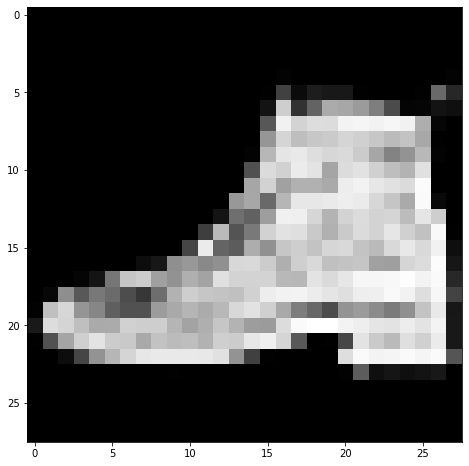

In [80]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

start_z = sample_z(1, 100)
G.eval()
fake = G(start_z.to(device))
plt.imshow(fake.detach().cpu()[0][0], cmap='gray')

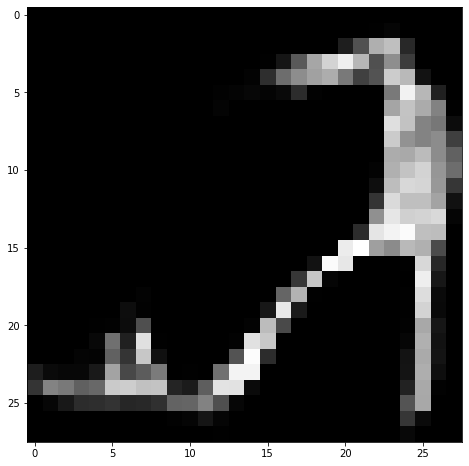

In [81]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

end_z = sample_z(1, 100)
G.eval()
fake = G(end_z.to(device))
plt.imshow(fake.detach().cpu()[0][0], cmap='gray')

In [82]:
diff = end_z - start_z
step = 16
zs = [z1] + [z1+diff*i/step for i in range(1, step+1)] + [z2]
print(len(zs))

18


<Figure size 864x576 with 0 Axes>

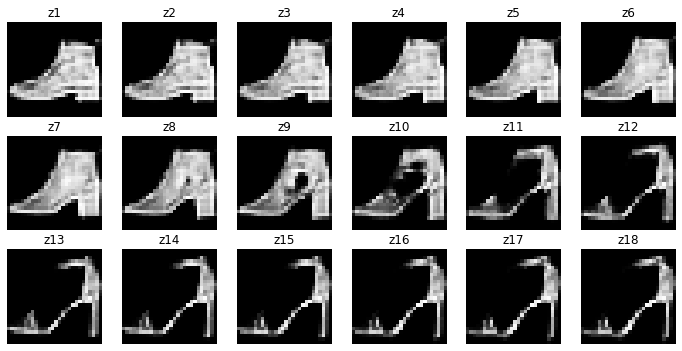

In [83]:
imgs = np.zeros((len(zs), 28, 28))
for i, z in enumerate(zs):
    imgs[i] = G(z.to(device)).detach().cpu().numpy()[0][0]

    
plt.rcParams['figure.figsize'] = (12, 8)
imshow(imgs, [f"z{i}" for i in range(1, len(zs)+1)])